
# Arsenal Passing Network Analysis

This notebook provides an analysis of Arsenal Football Club's passing network. The goal is to uncover insights into the team's playing style and key players.



## Setup

Import necessary libraries for data manipulation, network analysis, and visualization.


In [2]:
# Import libraries for data manipulation, network analysis, and visualization
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch
import pandas as pd


## Data Loading and Preprocessing

Load the dataset and perform initial data cleaning steps, including handling null values.


In [3]:
df= pd.read_csv(r"C:\Users\santo\Downloads\Arsenal_pass_network.csv")

null_values = df.isnull().sum()

In [4]:
# Display the count of null values
print("Null values in each column:")
print(null_values)

df.fillna(0, inplace=True)

Null values in each column:
Index                           0
id                              0
event_id                        0
minute                          0
second                          0
team_id                         0
player_id                       0
x                               0
y                               0
end_x                         381
end_y                         381
qualifiers                      0
is_touch                        0
blocked_x                    1568
blocked_y                    1568
goal_mouth_z                 1555
goal_mouth_y                 1555
is_shot                         0
card_type                       0
is_goal                         0
type_display_name               0
outcome_type_display_name       0
period_display_name             0
dtype: int64


In [5]:
df.columns

Index(['Index', 'id', 'event_id', 'minute', 'second', 'team_id', 'player_id',
       'x', 'y', 'end_x', 'end_y', 'qualifiers', 'is_touch', 'blocked_x',
       'blocked_y', 'goal_mouth_z', 'goal_mouth_y', 'is_shot', 'card_type',
       'is_goal', 'type_display_name', 'outcome_type_display_name',
       'period_display_name'],
      dtype='object')

In [6]:
print(df)
df = df[df['team_id']=='Arsenal']
df.rename(columns={'type_display_name': 'type'}, inplace=True)
df.rename(columns={'outcome_type_display_name': 'outcome'}, inplace=True)
df.rename(columns={'team_id': 'team'}, inplace=True)
df.rename(columns={'player_id': 'player'}, inplace=True)
df.rename(columns={'period_display_name': 'period'}, inplace=True)
df['recipient'] = df['player'].shift(-1)
df.head()

print(df.columns)

      Index          id  event_id  minute  second  team_id      player_id  \
0         1  2655015271         3       0       0  Arsenal    Declan Rice   
1         2  2655015309         4       0       3  Arsenal     David Raya   
2         3  2655015463         4       0      17      163         354291   
3         4  2655015485         5       0      18      163         373964   
4         5  2655015505         6       0      21      163         316077   
...     ...         ...       ...     ...     ...      ...            ...   
1577   1578  2655072739      1192      94      55  Arsenal  Cedric Soares   
1578   1579  2655072751      1193      94      57  Arsenal  Thomas Partey   
1579   1580  2655072769      1194      95       0  Arsenal   Jakub Kiwior   
1580   1581  2655072771      1195      95       4  Arsenal    Kai Havertz   
1581   1582  2655072779       527      95       5      163         373964   

         x     y  end_x  ...  blocked_x blocked_y  goal_mouth_z  goal_mouth


## Passing Network Generation

Creation of the passing network to identify patterns, key players, and potential tactical insights.


In [7]:
#check for index of first sub
sub = df.loc[df["type"] == "SubstitutionOff"].loc[df["team"] == "Arsenal"].iloc[0]["Index"]
mask_ars = (df.type== 'Pass') & (df.team == "Arsenal") & (df.index < sub) & (df.outcome== 'Successful')
#taking necessary columns
df_pass = df.loc[mask_ars, ['x', 'y', 'end_x', 'end_y', "player", "recipient"]]
df_pass["player"] = df_pass["player"].apply(lambda x: str(x).split()[-1])
df_pass["recipient"] = df_pass["recipient"].apply(lambda x: str(x).split()[-1])

In [8]:
scatter_df = pd.DataFrame()
for i, name in enumerate(df_pass["player"].unique()):
    passx = df_pass.loc[df_pass["player"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["recipient"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["player"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["recipient"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player"] = name
    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    #calculate number of passes
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player"] == name].count().iloc[0]

In [40]:
#adjust the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1200)


In [10]:
#counting passes between players
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player"], x["recipient"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold. You can try to investigate how it changes when you change it.
lines_df = lines_df[lines_df['pass_count']>0]


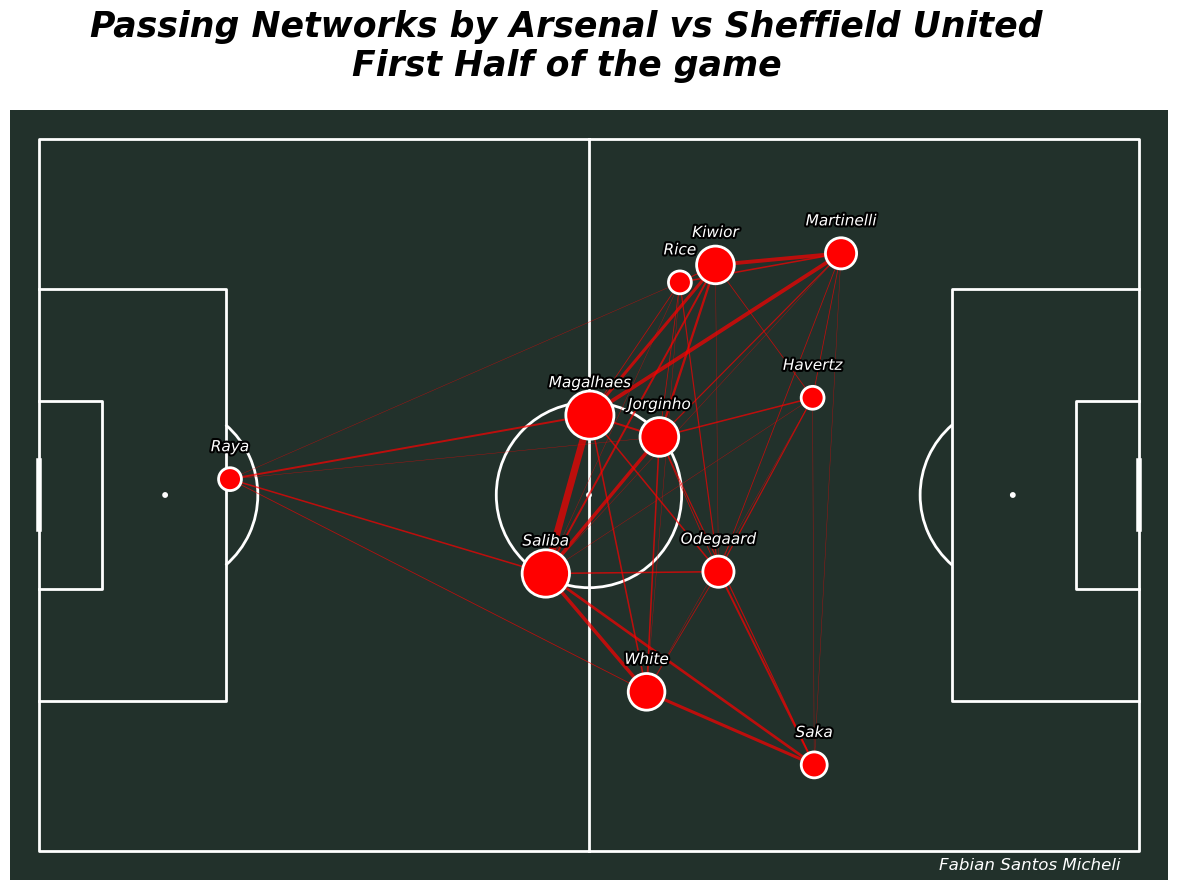

In [52]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from matplotlib import patheffects

from mplsoccer import Pitch
import matplotlib.pyplot as plt
from matplotlib import patheffects

fig, ax = plt.subplots(figsize=(18, 10))
pitch = Pitch(pitch_type='opta', pitch_color='#22312b', line_color='white', pitch_length=120, pitch_width=80)
pitch.draw(ax=ax)

# Scatter plot for players with red fill and white edge
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='white', linewidth=2, ax=ax, zorder=3)

# Text for player names with white color, italic style, and path effects for better visibility
# Offsetting the text slightly to avoid overlapping with the nodes
text_offset_x = 0  # Adjust this value as needed
text_offset_y = 4.55  # Adjust this value as needed
text_effects = [patheffects.withStroke(linewidth=3, foreground='black')]
for i, row in scatter_df.iterrows():
    ax.text(row.x + text_offset_x, row.y + text_offset_y, row.player, fontsize=11, color='white', ha='center', va='center',
            style='italic', path_effects=text_effects, zorder=4)

# Lines for passes with color changed to red
for i, row in lines_df.iterrows():
    player1 = row["pair_key"].split("_")[0]
    player2 = row['pair_key'].split("_")[1]
    player1_x = scatter_df.loc[scatter_df["player"] == player1]['x'].iloc[0]
    player1_y = scatter_df.loc[scatter_df["player"] == player1]['y'].iloc[0]
    player2_x = scatter_df.loc[scatter_df["player"] == player2]['x'].iloc[0]
    player2_y = scatter_df.loc[scatter_df["player"] == player2]['y'].iloc[0]
    num_passes = row["pass_count"]
    line_width = (num_passes / lines_df['pass_count'].max() * 5)  # Adjusted for better visualization
    pitch.lines(player1_x, player1_y, player2_x, player2_y, lw=line_width, zorder=2, color='red', alpha=0.7, ax=ax)

# Adjust title and subtitle with italic style
fig.suptitle("Passing Networks by Arsenal vs Sheffield United\nFirst Half of the game", fontsize=25, color='black', fontweight='bold', style='italic')

# Insert your name placeholder at the bottom of the visualization with italic style
ax.text(90, -2, 'Fabian Santos Micheli', fontsize=12, ha='center', va='center', color='white', style='italic')

plt.show()
plt.show()
fig.savefig(r'C:\Users\santo\OneDrive\Wyscout\PassNetwork_image_name.png')  


## Centralities generation 

Plotting of different centralization measures to better understand the team's dynamics.


In [39]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
G = nx.from_pandas_edgelist(df_pass, 'player', 'recipient', create_using=nx.DiGraph())


In [15]:
# Eigenvector centrality for each player
eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

# Betweenness centrality for each player
betweenness_centrality = nx.betweenness_centrality(G)

# Convert the centralities to DataFrames
df_eigenvector = pd.DataFrame(list(eigenvector_centrality.items()), columns=['player', 'eigenvector_centrality'])
df_betweenness = pd.DataFrame(list(betweenness_centrality.items()), columns=['player', 'betweenness_centrality'])


In [16]:
# Group by 'player' and count the number of passes for each player
no_passes = df_pass.groupby(['player']).size().reset_index(name='pass_count')

# Merge with the pass count DataFrame
result_df_eigenvector = pd.merge(no_passes, df_eigenvector, on='player', how='left')
result_df_betweenness = pd.merge(no_passes, df_betweenness, on='player', how='left')

# Calculate centralization indices for each player
result_df_eigenvector['centralisation_index_eigenvector'] = (result_df_eigenvector["eigenvector_centrality"].max() - result_df_eigenvector["eigenvector_centrality"]) / (10 * result_df_eigenvector["eigenvector_centrality"].sum())
result_df_betweenness['centralisation_index_betweenness'] = (result_df_betweenness["betweenness_centrality"].max() - result_df_betweenness["betweenness_centrality"]) / (10 * result_df_betweenness["betweenness_centrality"].sum())

# Sort the DataFrames based on centralization indices (from lowest to highest)
result_df_eigenvector.sort_values(by='centralisation_index_eigenvector', ascending=True, inplace=True)
result_df_betweenness.sort_values(by='centralisation_index_betweenness', ascending=True, inplace=True)

In [18]:
result_df_eigenvector.reset_index(drop=True, inplace=True)
result_df_betweenness.reset_index(drop=True, inplace=True)

# Print the resulting DataFrames
print("Eigenvector Centrality Table:")
print(result_df_eigenvector)

print("\nBetweenness Centrality Table:")
print(result_df_betweenness)


Eigenvector Centrality Table:
        player  pass_count  eigenvector_centrality  \
0       Saliba          30                0.384703   
1     Jorginho          20                0.363091   
2    Magalhaes          31                0.333077   
3       Kiwior          19                0.321383   
4   Martinelli          13                0.321383   
5        White          18                0.313071   
6     Odegaard          13                0.269859   
7         Saka           9                0.247988   
8         Raya           7                0.245484   
9         Rice           7                0.241486   
10     Havertz           7                0.227467   

    centralisation_index_eigenvector  
0                           0.000000  
1                           0.000661  
2                           0.001579  
3                           0.001937  
4                           0.001937  
5                           0.002191  
6                           0.003513  
7        

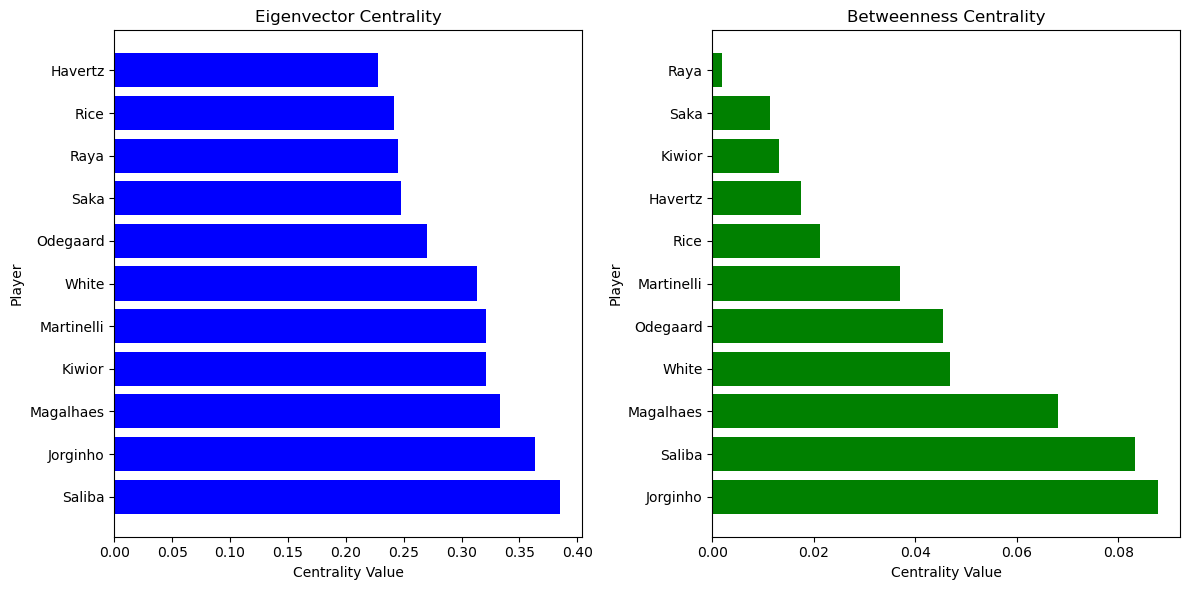

In [19]:
# Plotting
plt.figure(figsize=(12, 6))

# Eigenvector Centrality
plt.subplot(1, 2, 1)
plt.barh(result_df_eigenvector['player'], result_df_eigenvector['eigenvector_centrality'], color='blue')
plt.title('Eigenvector Centrality')
plt.xlabel('Centrality Value')
plt.ylabel('Player')

# Betweenness Centrality
plt.subplot(1, 2, 2)
plt.barh(result_df_betweenness['player'], result_df_betweenness['betweenness_centrality'], color='green')
plt.title('Betweenness Centrality')
plt.xlabel('Centrality Value')
plt.ylabel('Player')

plt.tight_layout()
plt.show()

In [20]:
no_passes = df_pass.groupby(['player']).x.count().reset_index()
no_passes.rename({'x':'pass_count'}, axis='columns', inplace=True)
#find one who made most passes
max_no = no_passes["pass_count"].max()
#calculate the denominator - 10*the total sum of passes
denominator = 10*no_passes["pass_count"].sum()
#calculate the nominator
nominator = (max_no - no_passes["pass_count"]).sum()
#calculate the centralisation index
centralisation_index = nominator/denominator
print("Centralisation index is ", centralisation_index)

Centralisation index is  0.09597701149425288
